In [ ]:
import pandas as pd
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
from datetime import timedelta

def yaml_to_csv(input_folder, output_file):
    
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    combined_data = []

    for month_path in Path(input_folder).iterdir():
        if not month_path.is_dir():
            continue

        for file_path in month_path.glob('*.yaml'):
            with open(file_path, 'r') as file:
                data = yaml.safe_load(file)
                combined_data.append(pd.DataFrame(data))

    if combined_data:
        combined_df = pd.concat(combined_data, ignore_index=True)
        combined_df.to_csv(output_file, index=False)
        print(f"Data saved to {output_file}")
    else:
        print("No data found.")

if __name__ == "__main__":
    input_folder = "D:/projects/stock/data"
    output_file = "D:/projects/stock/output/combined.csv"

    yaml_to_csv(input_folder, output_file)

Data saved to D:/projects/stock/output/combined.csv


In [49]:
import pandas as pd
from pathlib import Path


file_path = Path("D:/projects/stock/output/combined.csv")
df = pd.read_csv(file_path)

df.head()

,Ticker,close,date,high,low,month,open,volume
0,SBIN,602.95,2023-10-03 05:30:00,604.9,589.60,2023-10,596.6,15322196
1,BAJFINANCE,7967.60,2023-10-03 05:30:00,7975.5,7755.00,2023-10,7780.8,944555
2,TITAN,3196.25,2023-10-03 05:30:00,3212.5,3114.40,2023-10,3148.8,1007308
3,ITC,439.75,2023-10-03 05:30:00,442.9,439.25,2023-10,441.0,7481883
4,TCS,3513.85,2023-10-03 05:30:00,3534.2,3480.10,2023-10,3534.2,1948148


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14200 entries, 0 to 14199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  14200 non-null  object 
 1   close   14200 non-null  float64
 2   date    14200 non-null  object 
 3   high    14200 non-null  float64
 4   low     14200 non-null  float64
 5   month   14200 non-null  object 
 6   open    14200 non-null  float64
 7   volume  14200 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 887.6+ KB


In [ ]:
import pandas as pd
from pathlib import Path

def analyse_data():
    file_path = Path("D:/projects/stock/output/combined.csv")
    df = pd.read_csv(file_path)

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year

    # For yearly analysis
    yearly_data = df.groupby(['Ticker', 'year']).agg(
        first_open=('open', 'first'),
        last_close=('close', 'last')
    ).reset_index()

    yearly_data['yearly_return'] = ((yearly_data['last_close'] - yearly_data['first_open']) / 
                                    yearly_data['first_open']) * 100
    
    top_10_green_stocks = yearly_data.nlargest(10, 'yearly_return')
    top_10_loss_stocks = yearly_data.nsmallest(10, 'yearly_return')

    green_stocks = (yearly_data['yearly_return'] > 0).sum()
    loss_stocks = (yearly_data['yearly_return'] <= 0).sum()
    
    
    df["average_price"] = (df["open"] + df["close"]) / 2
    avg_price = df["average_price"].mean()

    avg_volume = df["volume"].mean()

    print(f"Top 10 Green Stocks:{top_10_green_stocks}")
    print(f"\n Top 10 Loss Stocks:{top_10_loss_stocks}")
    print(f"\n Number of Green Stocks: {green_stocks}")
    print(f"Number of Loss Stocks: {loss_stocks}")
    print(f"Avg Price: {avg_price:.2f}")
    print(f"Avg Volume: {avg_volume:.2f}")

    return top_10_green_stocks, top_10_loss_stocks

top_10_green_stocks, top_10_loss_stocks = analyse_data()


Top 10 Green Stocks:        Ticker  year  first_open  last_close  yearly_return
95       TRENT  2024     3061.80     6652.80     117.283951
61         M&M  2024     1729.40     3012.95      74.219382
19  BHARTIARTL  2024     1031.95     1569.30      52.071321
17         BEL  2024      184.80      280.85      51.975108
94       TRENT  2023     2074.30     3054.95      47.276190
81   SUNPHARMA  2024     1261.00     1795.30      42.371134
71   POWERGRID  2024      237.90      336.95      41.635141
11  BAJAJ-AUTO  2024     6770.00     9481.65      40.053914
79  SHRIRAMFIN  2024     2055.55     2850.05      38.651456
91       TECHM  2024     1273.00     1747.45      37.270228

 Top 10 Loss Stocks:        Ticker  year  first_open  last_close  yearly_return
49  INDUSINDBK  2024     1598.95      998.20     -37.571531
7   ASIANPAINT  2024     3403.00     2472.20     -27.352336
1     ADANIENT  2024     2852.30     2228.00     -21.887599
65   NESTLEIND  2024     2665.00     2247.30     -15.673546

In [58]:
df['daily_return'] = df.groupby('Ticker')['close'].pct_change()
volatility = df.groupby('Ticker')['daily_return'].std().nlargest(10)
print(f"Top 10 Tickers with the Highest Volatility: {volatility}")

Top 10 Tickers with the Highest Volatility: Ticker
ADANIENT      0.028601
ADANIPORTS    0.026029
BEL           0.023283
TRENT         0.023074
ONGC          0.022247
BPCL          0.022069
SHRIRAMFIN    0.021687
COALINDIA     0.021411
HINDALCO      0.019587
NTPC          0.019475
Name: daily_return, dtype: float64


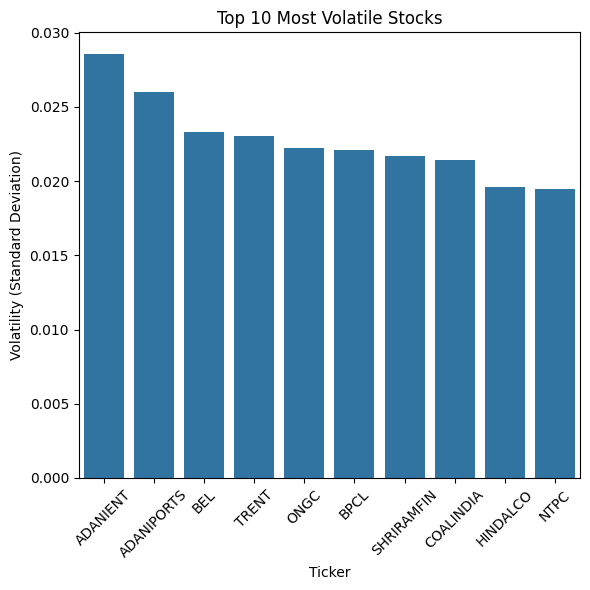

In [60]:
plt.figure(figsize=(6, 6))
sns.barplot(x=volatility.index, y=volatility.values)
plt.title('Top 10 Most Volatile Stocks')
plt.xlabel('Ticker')
plt.ylabel('Volatility (Standard Deviation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_10_volatile_stocks.png')
plt.show()

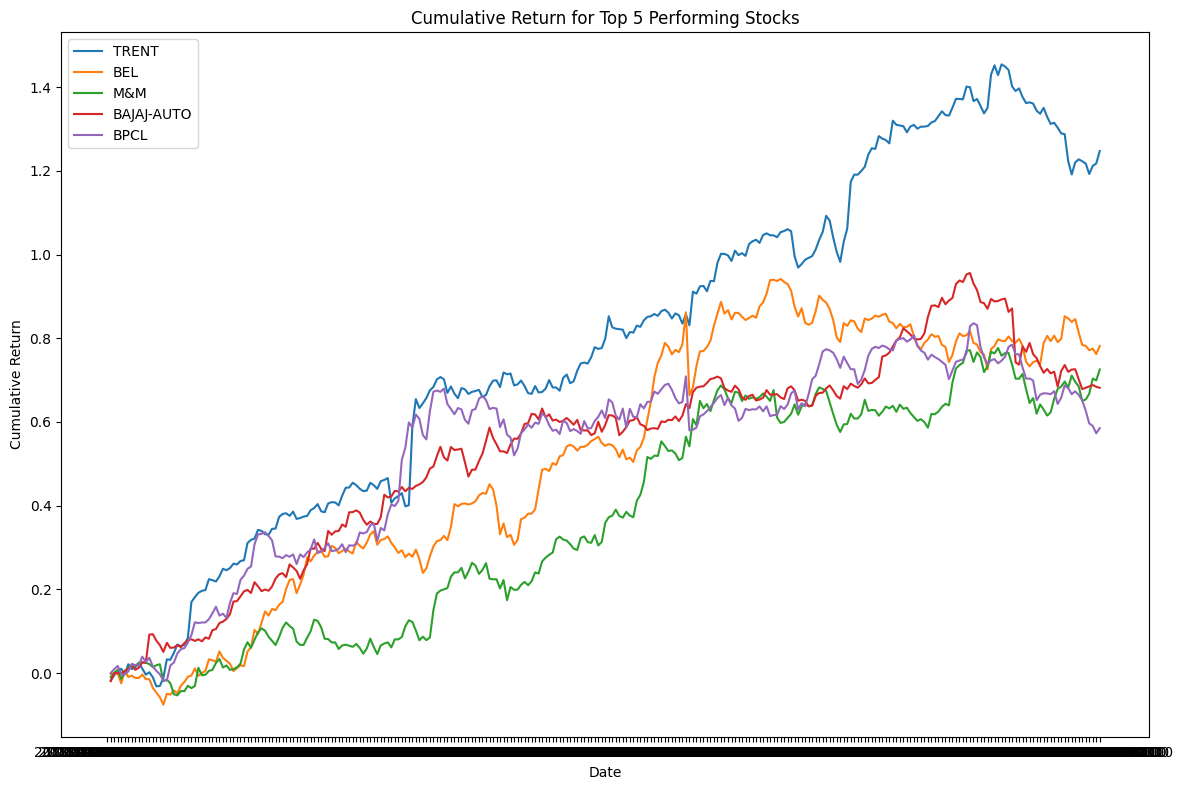

In [67]:
df['daily_return'] = df.groupby('Ticker')['close'].pct_change()
df['cumulative_return'] = df.groupby('Ticker')['daily_return'].cumsum()
top_5_stocks = df.groupby('Ticker')['cumulative_return'].last().nlargest(5).index
    
plt.figure(figsize=(12, 8))
for ticker in top_5_stocks:
  stock_data = df[df['Ticker'] == ticker]
  plt.plot(stock_data['date'], stock_data['cumulative_return'], label=ticker)

plt.title('Cumulative Return for Top 5 Performing Stocks')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.savefig('top_5_cumulative_return.png')
plt.show()

In [72]:
print(f"Top 5 high cumulative return tickers: {top_5_stocks}")

Top 5 high cumulative return tickers: Index(['TRENT', 'BEL', 'M&M', 'BAJAJ-AUTO', 'BPCL'], dtype='object', name='Ticker')


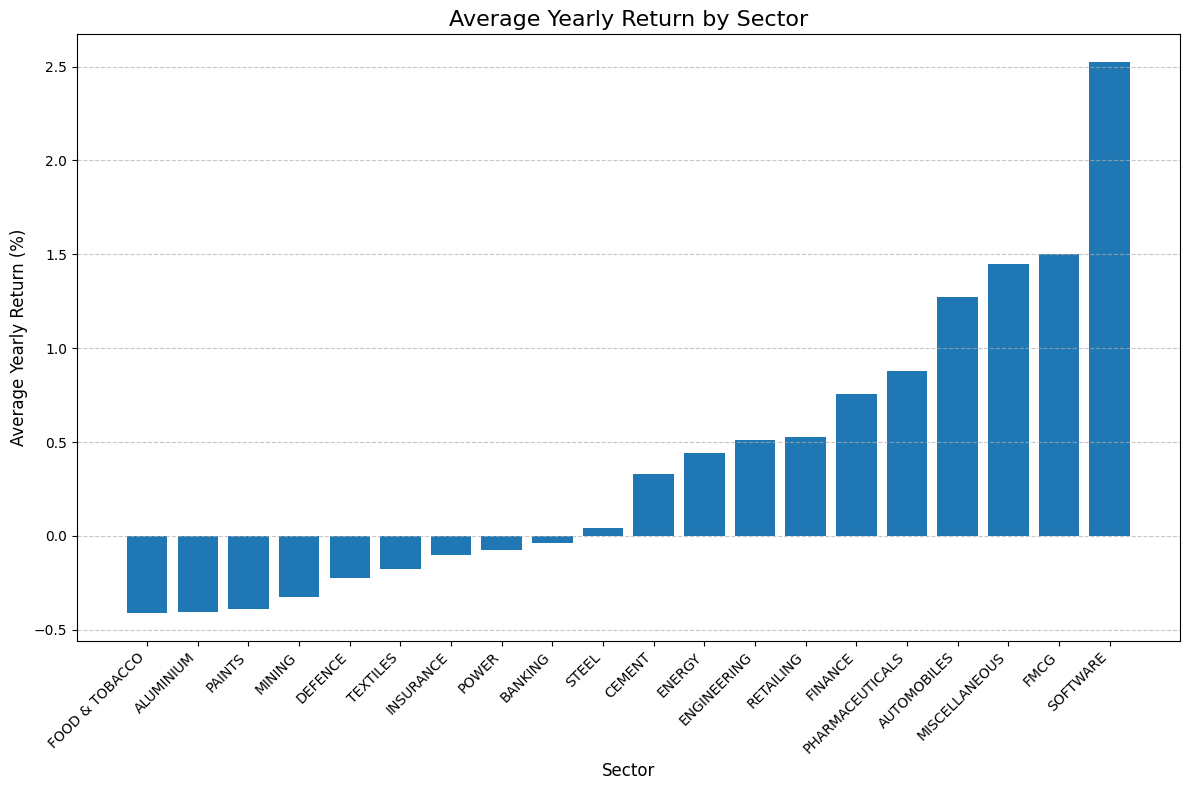

In [90]:
import pandas as pd

sector_data = pd.read_csv('D:/projects/stock/output/sector_data.csv')
combined_data = pd.read_csv('D:/projects/stock/output/combined.csv')

sector_data['Symbol'] = sector_data['Symbol'].str.split(': ').str[-1]

merged_data = combined_data.merge(sector_data, left_on='Ticker', right_on='Symbol', how='left')

merged_data['date'] = pd.to_datetime(merged_data['date'])

merged_data['year'] = merged_data['date'].dt.year

# yearly returns for each stock 
yearly_returns = (
    merged_data.groupby(['Ticker', 'sector', 'year'])['close']
    .last()
    .pct_change()
    .dropna()
    .reset_index(name='yearly_return')
)

sector_avg_returns = yearly_returns.groupby('sector')['yearly_return'].mean().sort_values()

plt.figure(figsize=(12, 8))
plt.bar(sector_avg_returns.index, sector_avg_returns.values)

plt.title('Average Yearly Return by Sector', fontsize=16)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Average Yearly Return (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('sector_performance.png')
plt.show()


In [76]:
merged_data.to_csv('merged_dataset1.csv', index=False)

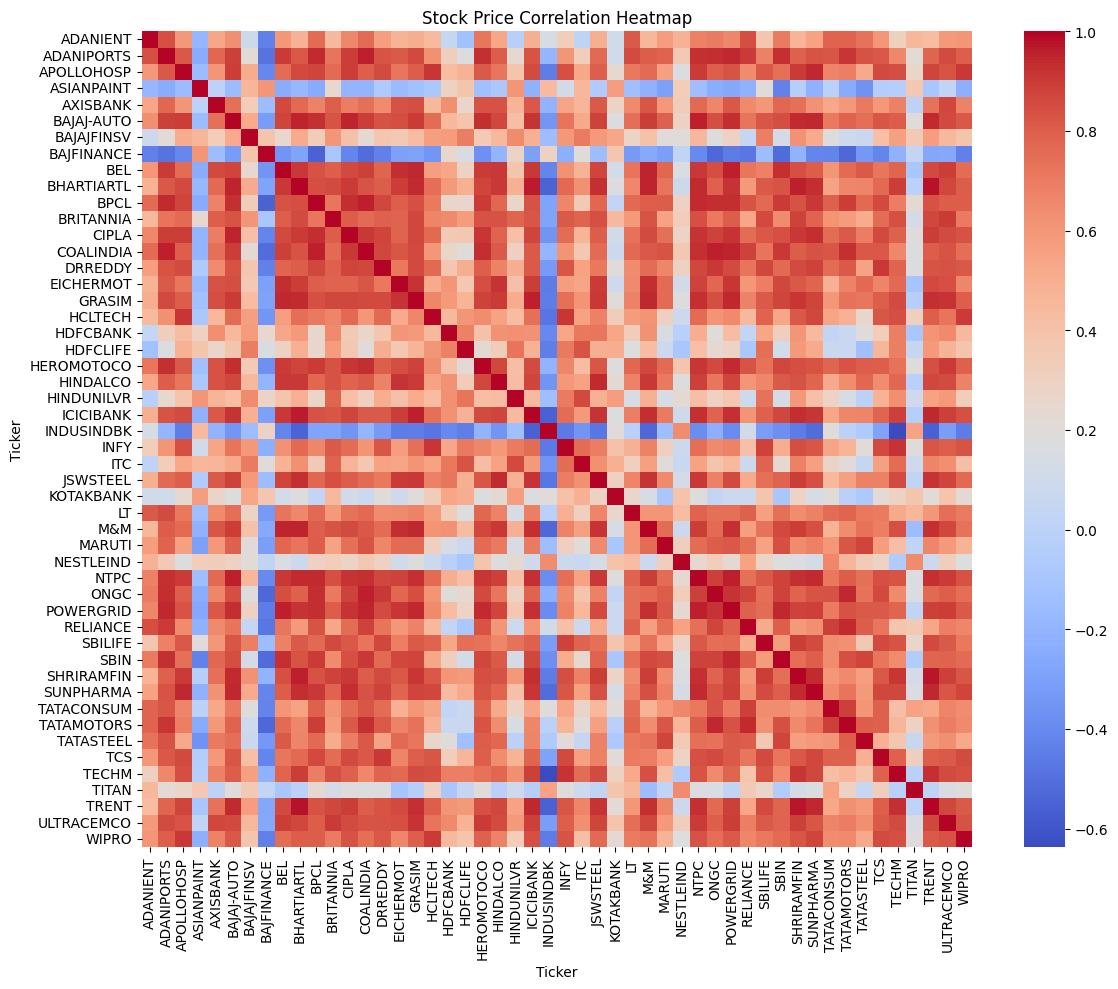

In [91]:
stock_prices = df.pivot(index='date', columns='Ticker', values='close')
correlation_matrix = stock_prices.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title('Stock Price Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()